In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_path = "/scratch2/sfgd/sparse_data_genie_fhc_numu_hittag/"
N_files = len(os.listdir(data_path))

Let's check the content of the event files

In [4]:
f = np.load(data_path + 'event1.npz')
keys = list(f.keys())
print(keys)

['x', 'c', 'y', 'verPos']


In [5]:
for k in keys :
    print(f[k].shape)

(158, 12)
(158, 3)
(158, 1)
(3,)


In [6]:
for i in range(4):
    for j in range(3):
        print(1/2*(i+j)*(1+i+j) +j )

0.0
2.0
5.0
1.0
4.0
8.0
3.0
7.0
12.0
6.0
11.0
17.0


In [7]:
def plot_stats(evt):
        fig, axs = plt.subplots(4,3, figsize = (10,10))
        i=0
        names = ["HitTime", "HitCharge", "HitMPPCXY", "HitMPPCXZ", "HitMPPCYZ","HitNumberXY", "HitNumberXZ", "HitNumberYZ", "HitAdjacent", "HitDiagonal", "HitCorner", "HitDistance2Vertex"]
        for idx,ax in enumerate(fig.axes):
                f_split = [evt["x"][(evt["y"]==j).squeeze(1),i] for j in range(1,4)]
                ax.hist(f_split, histtype= "barstacked", bins = 25, color = ["yellow", "red", "blue"])
                ax.set_title(names[i])
                i+=1
        fig.legend(["multi", "single", "other"])
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
           
                        wspace=0.4, 
                        hspace=0.4)
        plt.show()

In [8]:
def display_3D(evt):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    filled_marker_style = dict(marker='o', linestyle=':', markersize=15,
                           
                           markerfacecolor='tab:blue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='brown')
    for i in range(1,4):
        cat_coords = evt["c"][(evt["y"]==i).squeeze(1),:]
        ax.scatter(cat_coords[:,0], cat_coords[:,1], cat_coords[:,2], color = c_list[i-1], edgecolor = "black", alpha = 1, label = labels[i-1])
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

In [9]:
def show_event(evt_id = None,plot_stat = False):
    #show a random event from a dataset
    if evt_id == None :
        evt_id = np.random.randint(1,N_files)
    evt = np.load(data_path + "event%d.npz"%evt_id)
    display_3D(evt)
    plt.title("Event #%d, %d hits"%(evt_id, len(evt["c"])), fontsize = 16)
    plt.show()
    plt.clf()
    if plot_stat:
        plot_stats(evt)

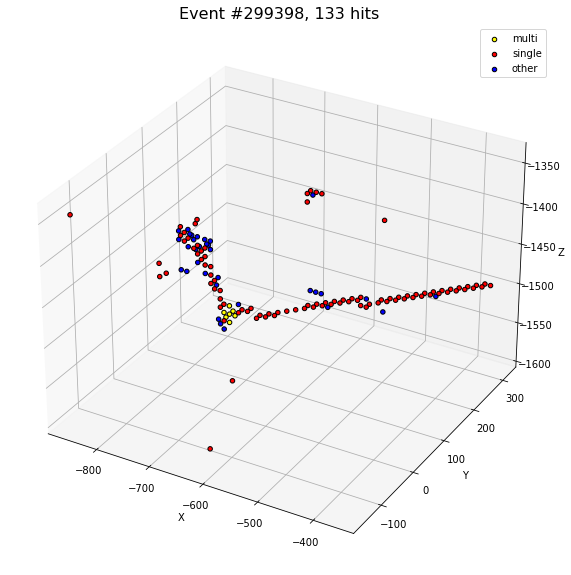

<Figure size 432x288 with 0 Axes>

In [10]:
show_event()

Global Dataset statistics

In [11]:
# lengths = []
# for i in range(N_files):
#     evt = np.load(data_path + "event%d.npz"%i)
#     lengths.append(len(evt["x"]))

In [12]:
# plt.hist(lengths, bins = 50)

Testing a simple pytorch dataset from directly loading the npz files

In [13]:
import torch
from torch.utils.data import Sampler, RandomSampler, Dataset, BatchSampler

In [14]:
class SimpleDataset(Dataset):
    def __init__(self, fpath):
        self.data_path = fpath
        self.len = len(os.listdir(self.data_path))

    def __getitem__(self,x):
        npz_file = np.load(self.data_path + "event%d.npz"%(x))
        n_hits = len(npz_file["c"])
        p2d = (0,0,0,64 - n_hits%64)
        mask = torch.zeros(n_hits+ 64 - n_hits%64)
        mask[:n_hits] = 1
        t_coords, t_vals = torch.nn.functional.pad(torch.tensor(npz_file["c"]), p2d, value = 0), torch.nn.functional.pad(torch.tensor(npz_file["y"]), p2d, value = 0)
        return {"coords": t_coords, "values": t_vals, "mask": mask }
    def __len__(self):
        return self.len

In [15]:
class LenMatchBatchSampler(torch.utils.data.BatchSampler):
    def __init__(self, data_source, sampler, batch_size, drop_last):
        super().__init__(sampler, batch_size, drop_last)
        self.dataset = data_source
    def __iter__(self):
        buckets = [[]] * 5000
        yielded = 0
        
        for idx in self.sampler:
            #s = self.sampler.data_source[idx]
            s = self.dataset[idx]
            L = s["coords"].shape[0]
            
            # if isinstance(s, tuple):
            #     L = s[0]["mask"].sum()
            # else:
            #     L = s["mask"].sum()
            # if torch.rand(1).item() < 0.1: L = int(1.5*L)
            L = max(0, L // 64)
            if len(buckets[L]) == 0:
                buckets[L] = []
            buckets[L].append(idx)

            if len(buckets[L]) == self.batch_size:
                batch = list(buckets[L])
                yield batch
                yielded += 1
                buckets[L] = []

        batch = []
        leftover = [idx for bucket in buckets for idx in bucket]
        print("loop finished")
        print(leftover)
        for idx in leftover:
            batch.append(idx)
            if len(batch) == self.batch_size:
                print("end yield")
                print(batch)
                yielded += 1
                yield batch
                batch = []

        if len(batch) > 0 and not self.drop_last:
            yielded += 1
            yield batch

In [16]:
dataset = SimpleDataset(data_path)

In [17]:
rand_sampler = RandomSampler(dataset)
lenmatch_sampler = LenMatchBatchSampler(dataset, rand_sampler, batch_size= 256, drop_last=False)

In [18]:
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler= lenmatch_sampler)

Experimenting with self attention and other layers

In [19]:
seq_length = 4
emb_dim = 8

X = torch.randn(emb_dim, seq_length)

W = torch.randn(emb_dim, emb_dim)
b = torch.randn(emb_dim, seq_length)
perm = torch.randperm(seq_length)

X_perm = X[:,perm]
print(perm)
print(torch.matmul(W,X) +b - (torch.matmul(W, X_perm)+b)[:,perm])
print(b)

tensor([3, 1, 2, 0])
tensor([[-2.4433,  0.0000,  0.0000,  2.4433],
        [-0.9177,  0.0000,  0.0000,  0.9177],
        [-1.4416,  0.0000,  0.0000,  1.4416],
        [-1.2338,  0.0000,  0.0000,  1.2338],
        [ 3.2085,  0.0000,  0.0000, -3.2085],
        [ 0.7826,  0.0000,  0.0000, -0.7826],
        [-1.2610,  0.0000,  0.0000,  1.2610],
        [-1.7872,  0.0000,  0.0000,  1.7872]])
tensor([[-0.5088, -0.5406,  0.4736,  1.9345],
        [-0.7784, -0.3730,  1.0213,  0.1393],
        [-0.7445,  1.4675, -1.3732,  0.6971],
        [-0.2447,  1.3159,  0.3761,  0.9891],
        [ 1.3213, -0.7462,  0.6875, -1.8872],
        [ 0.6006, -0.3263, -0.2376, -0.1820],
        [-0.5097,  0.6826, -0.8341,  0.7513],
        [-0.2380,  0.1437, -0.9487,  1.5491]])


In [20]:
lin = torch.nn.Linear(emb_dim,emb_dim, bias = False)
print(torch.transpose(X,0,1))
print(torch.transpose(X_perm,0,1))
print(lin(torch.transpose(X,0,1)) - lin(torch.transpose(X_perm,0,1)))


tensor([[-1.6804,  1.0616, -0.4813, -0.7037,  0.9702, -0.3520,  2.4276,  0.0077],
        [-0.0879, -0.0464,  0.0092, -0.1705,  1.8239,  0.4915,  1.5660, -0.8454],
        [-0.3423,  0.1974, -0.3141, -0.1429,  1.9591, -0.1362, -1.4558,  0.9991],
        [ 0.0705, -1.8933, -0.0387,  0.3611,  1.3727, -0.1757, -0.6639, -0.0656]])
tensor([[ 0.0705, -1.8933, -0.0387,  0.3611,  1.3727, -0.1757, -0.6639, -0.0656],
        [-0.0879, -0.0464,  0.0092, -0.1705,  1.8239,  0.4915,  1.5660, -0.8454],
        [-0.3423,  0.1974, -0.3141, -0.1429,  1.9591, -0.1362, -1.4558,  0.9991],
        [-1.6804,  1.0616, -0.4813, -0.7037,  0.9702, -0.3520,  2.4276,  0.0077]])
tensor([[-1.7238, -1.5124,  0.5680,  0.0253, -0.5180, -0.7181,  0.6264,  0.4204],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.7238,  1.5124, -0.5680, -0.0253,  0.5180,  0.7181, -0.6264, -0.4204]],
       grad_f

In [22]:
from transformer_encoder import EncoderLayer,Model
enc_lay = EncoderLayer(64,32,64//16, dropout = 0.01)
x = torch.ones(1,5,4)
mask = torch.ones(1,5)

model = Model(64,32,4,5,4,3)
model(x,mask)

torch.Size([1, 5, 64])


tensor([[[-0.8723, -0.3193, -0.1472],
         [-1.0414, -0.3283, -0.1869],
         [-1.0208, -0.3756, -0.2481],
         [-0.9429, -0.3458, -0.1566],
         [-1.0644, -0.3049, -0.1119]]], grad_fn=<StackBackward0>)